# Action Recognition from HMDB dataset

## load data and preprocess

In [ ]:
pip install keras-video-generators

In [ ]:
import os
import glob
import keras
from keras_video import VideoFrameGenerator
from google.colab import drive
import tensorflow as tf
import matplotlib.pyplot as plt


In [ ]:
#import keras layers
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, GlobalMaxPool2D
from keras.layers import TimeDistributed, GRU, Dense, Dropout, Flatten, LSTM
from tensorflow.keras import regularizers

In [ ]:
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
cd /content/gdrive/Shareddrives/

/content/gdrive/Shareddrives


In [ ]:
root_logdir = os.path.join(os.curdir, "logs")
def get_run_logdir(name):
    return os.path.join(root_logdir, name)
run_logdir = get_run_logdir('try')
tb_cb = keras.callbacks.TensorBoard(run_logdir)

In [ ]:
for i in glob.glob('final2040/HMDB_more/*'):
  print(i.split(os.path.sep)[2])

throw
walk
wave
swing_baseball
hit
catch
cartwheel
clap
chew
climb
climb_stairs
dive
draw_sword
dribble
drink
eat
fall_floor
flic_flac
fencing
golf
handstand
pushup
ride_horse
ride_bike
run
shake_hands
shoot_ball
shoot_bow
situp
shoot_gun
somersault
stand
sword_exercise
sword
talk
turn
hug
jump
kick
kick_ball
kiss
laugh
pick
pour
pullup
punch
push
brush_hair
sit
smile
smoke


In [ ]:
# use sub directories names as classes
classes = [i.split(os.path.sep)[2] for i in glob.glob('final2040/HMDB_more/*')]
classes.sort()
print(classes)

# some global params
SIZE = 224
CHANNELS = 3
NBFRAME = 5
BS = 15

# pattern to get videos and classes
glob_pattern='final2040/HMDB_more/{classname}/*.avi'

# for data augmentation
data_aug = keras.preprocessing.image.ImageDataGenerator(
    zoom_range=.1,
    horizontal_flip=True,
    rotation_range=8,
    width_shift_range=.2,
    height_shift_range=.2)


['brush_hair', 'cartwheel', 'catch', 'chew', 'clap', 'climb', 'climb_stairs', 'dive', 'draw_sword', 'dribble', 'drink', 'eat', 'fall_floor', 'fencing', 'flic_flac', 'golf', 'handstand', 'hit', 'hug', 'jump', 'kick', 'kick_ball', 'kiss', 'laugh', 'pick', 'pour', 'pullup', 'punch', 'push', 'pushup', 'ride_bike', 'ride_horse', 'run', 'shake_hands', 'shoot_ball', 'shoot_bow', 'shoot_gun', 'sit', 'situp', 'smile', 'smoke', 'somersault', 'stand', 'swing_baseball', 'sword', 'sword_exercise', 'talk', 'throw', 'turn', 'walk', 'wave']


In [ ]:
# Create video frame generator
train = VideoFrameGenerator(
    classes=classes, 
    glob_pattern=glob_pattern,
    nb_frames=NBFRAME,
    split=.2, 
    shuffle=True,
    batch_size=BS,
    target_shape= (SIZE,SIZE),
    nb_channel=CHANNELS,
    transformation=data_aug,
    use_frame_cache=True)

Warning, `split` argument is replaced by `split_val`, please condider to change your source code.The `split` argument will be removed in future releases.


class brush_hair, validation count: 21, train count: 87
class cartwheel, validation count: 21, train count: 86
class catch, validation count: 20, train count: 82
class chew, validation count: 21, train count: 88
class clap, validation count: 26, train count: 104
class climb, validation count: 21, train count: 87
class climb_stairs, validation count: 22, train count: 90
class dive, validation count: 25, train count: 102
class draw_sword, validation count: 20, train count: 83
class dribble, validation count: 29, train count: 116
class drink, validation count: 32, train count: 132
class eat, validation count: 21, train count: 87
class fall_floor, validation count: 27, train count: 109
class fencing, validation count: 23, train count: 93
class flic_flac, validation count: 21, train count: 86
class golf, validation count: 21, train count: 84
class handstand, validation count: 22, train count: 91
class hit, validation count: 25, train count: 102
class hug, validation count: 23, train count: 

In [ ]:
#get validation data
valid = train.get_validation_generator()

Total data: 51 classes for 1335 files for validation


In [ ]:
# # setup tensorboard, directories
# !rm -rf ./logs
# !mkdir ./logs/
# !mkdir ./logs/base_model

# # log_dir="./logs/base_model/"

# NAME='base_model'
# log_dir = os.path.join("logs",NAME)
# # tensorboard = TensorBoard(log_dir = tboard_log_dir)

# def tensorboard_callback(exp_name):
#   return tf.keras.callbacks.TensorBoard(log_dir=log_dir + exp_name, profile_batch=0, histogram_freq=1)

# # launch tensorboard with specific directory
# %load_ext tensorboard
# %tensorboard --logdir logs/base_model 


# # log_dir = os.path.join("logs",NAME)
# # tensorboard = TensorBoard(log_dir = tboard_log_dir)

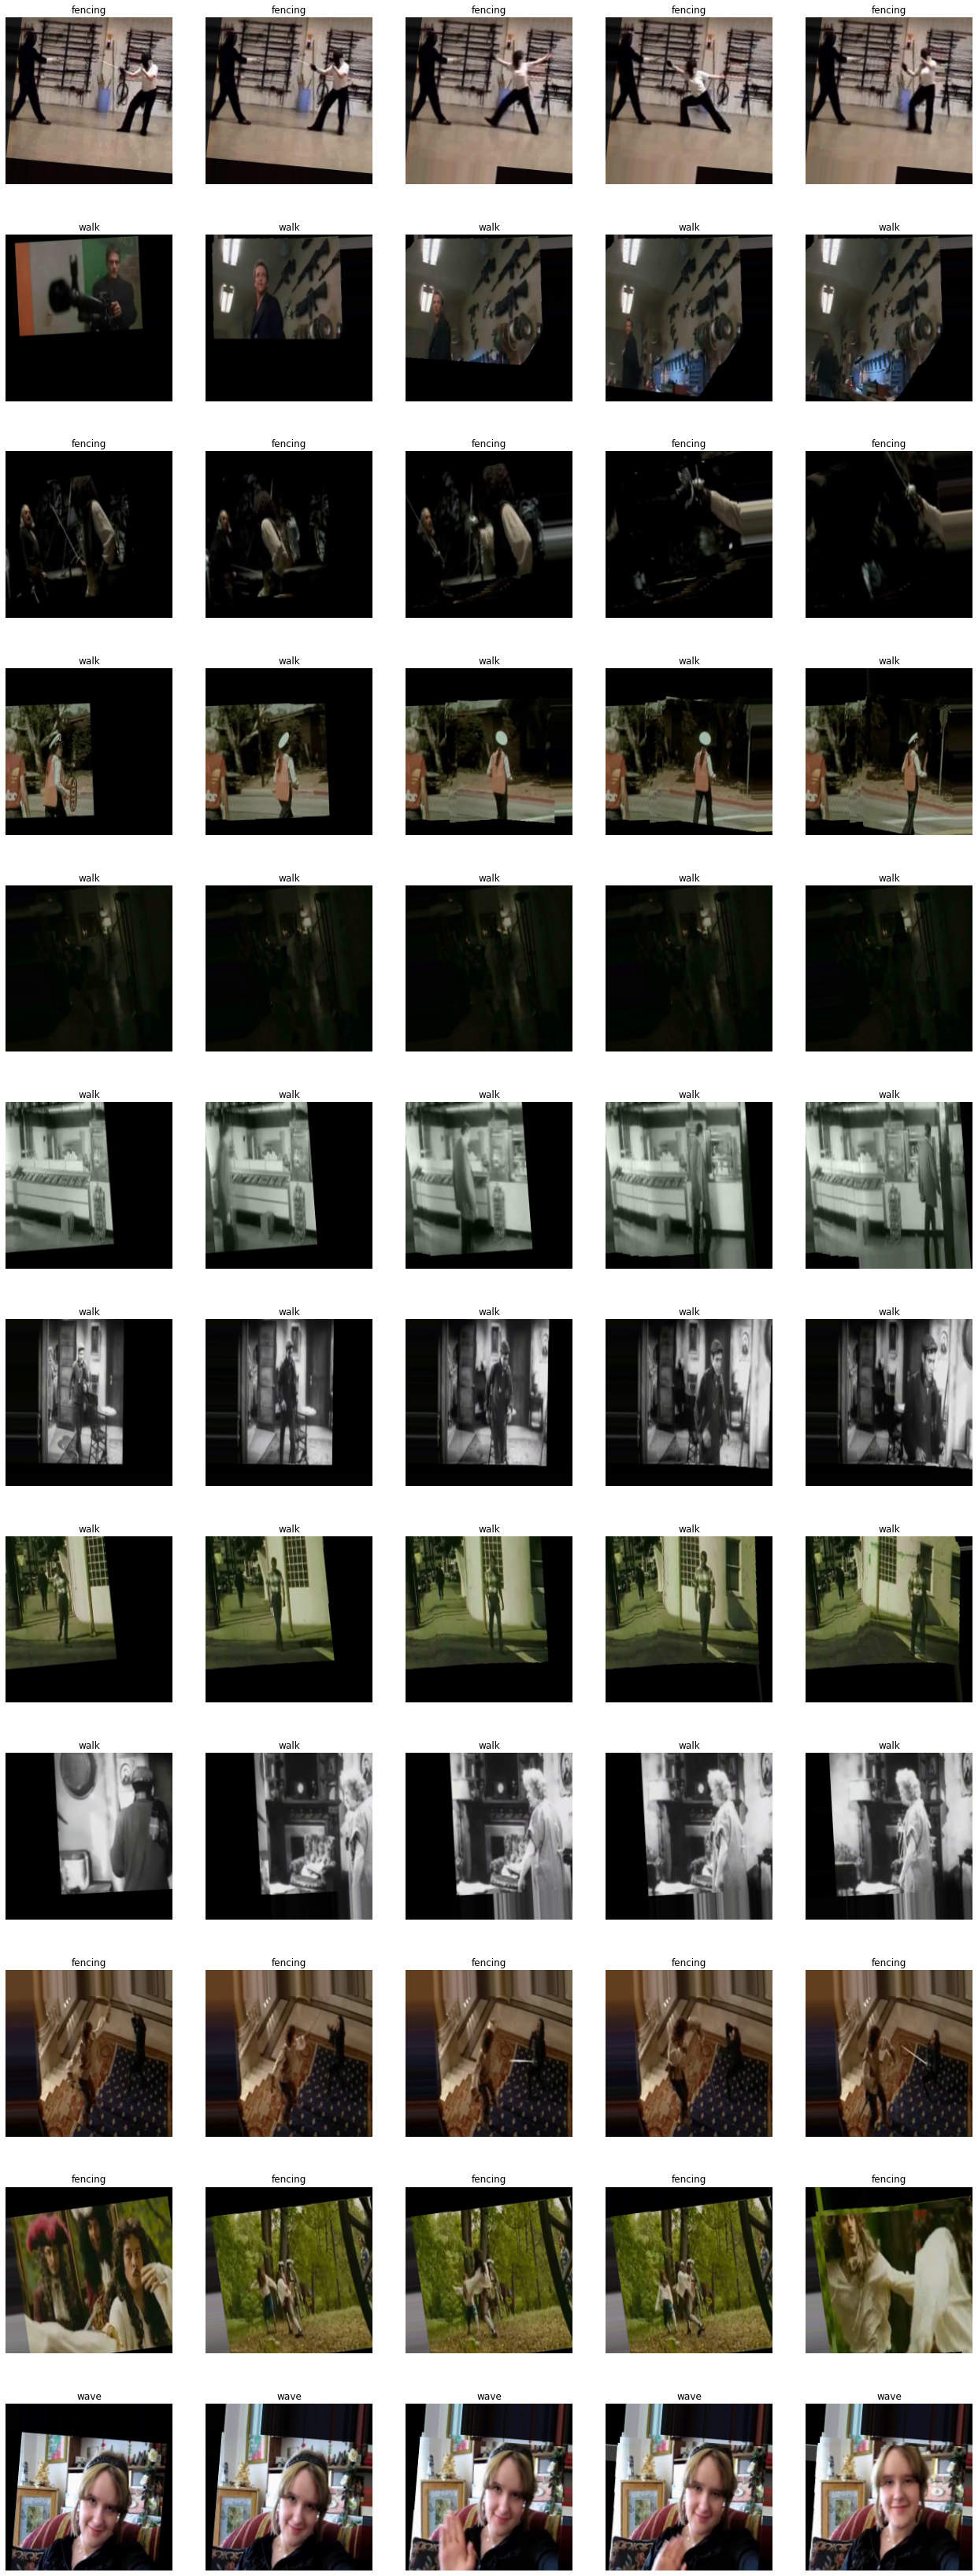

In [ ]:
import keras_video.utils
keras_video.utils.show_sample(train)

## baseline model

In [ ]:
def build_head(shape=(SIZE, SIZE, 3)):
    momentum = .9
    model = keras.Sequential()
    model.add(Conv2D(64, (3,3), input_shape=shape,
        padding='same', activation='relu'))
    model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(MaxPool2D())
    
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(MaxPool2D())
    
    model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(MaxPool2D())
    
    model.add(Conv2D(512, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(512, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    # flatten...
    model.add(GlobalMaxPool2D())
    return model

In [ ]:
def build_head(shape=(SIZE, SIZE, 3)):
    model = keras.Sequential()
    momentum = .9

    model.add(Conv2D(64, (3,3), input_shape=shape,
        padding='same', activation='relu'))
    model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(MaxPool2D())
    
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(MaxPool2D())
    
    model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(MaxPool2D())
    
    model.add(Conv2D(512, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(512, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    # flatten...
    model.add(GlobalMaxPool2D())
    return model

In [ ]:
nbout = len(classes)
def action_model(shape=(5, SIZE, SIZE, 3), nbout=nbout):
    # Create our head with (112, 112, 3) input shape
    head = build_head(shape[1:])
    # then create our final model
    model = keras.Sequential()
    # add the head with (5, 112, 112, 3) shape
    model.add(TimeDistributed(head, input_shape=shape))
    # here, you can also use GRU or LSTM
    model.add(LSTM(64))
    # and finally, we make a decision network
    model.add(Dense(1024, kernel_initializer='he_normal', activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(512, kernel_initializer='he_normal', activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(128, kernel_initializer='he_normal', activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(64, kernel_initializer='he_normal', activation='relu'))
    model.add(Dense(nbout, activation='softmax'))
    return model

In [ ]:
model = action_model(nbout=nbout)
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_4 (TimeDist (None, 5, 512)            4689216   
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                147712    
_________________________________________________________________
dense_20 (Dense)             (None, 1024)              66560     
_________________________________________________________________
dropout_12 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_13 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 128)             

### AlexNet accuracy 0.64



In [ ]:
nbout = len(classes)
def build_Alexnet(shape=(SIZE, SIZE, 3), nbout = nbout):
    model = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(224,224,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    ])
    return model

def action_model(shape=(5, SIZE, SIZE, 3), nbout=nbout):
    head = build_Alexnet(shape[1:])
    model = keras.Sequential()
    model.add(TimeDistributed(head, input_shape=shape))
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True)))
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)))
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)))
    model.add(Dense(256, kernel_initializer='he_normal', activation='relu'))
    model.add(Dropout(.5))
    # model.add(Dense(512, kernel_initializer='he_normal', activation='relu'))
    # model.add(Dropout(.5))
    # model.add(Dense(128, kernel_initializer='he_normal', activation='relu'))
    # model.add(Dropout(.5))
    # model.add(Dense(64, kernel_initializer='he_normal', activation='relu'))
    model.add(Dense(nbout, activation='softmax'))
    return model

INSHAPE=(NBFRAME,SIZE,SIZE, CHANNELS) # (5, 224, 224, 3)
model_2 = action_model(INSHAPE, len(classes))
optimizer = keras.optimizers.SGD(0.0001)
model_2.compile(
    optimizer,
    'categorical_crossentropy',
    metrics=['acc']
)


EPOCHS=200
cb1 =   keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.7, patience=3, verbose=1, mode='auto', min_lr=1e-15)
cb2 =   keras.callbacks.EarlyStopping(monitor='val_acc', patience=30, restore_best_weights=True)

history3 = model_2.fit_generator(
    train,
    validation_data=valid,
    verbose=1,
    epochs=EPOCHS,
    callbacks=[cb1, cb2]
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/200
50/50 [==============================] - 40s 669ms/step - loss: 1.3315 - acc: 0.3513 - val_loss: 1.3956 - val_acc: 0.1076
Epoch 2/200
50/50 [==============================] - 31s 615ms/step - loss: 1.2945 - acc: 0.4958 - val_loss: 1.3559 - val_acc: 0.5347
Epoch 3/200
50/50 [==============================] - 31s 622ms/step - loss: 1.2632 - acc: 0.5552 - val_loss: 1.3184 - val_acc: 0.5868
Epoch 4/200
50/50 [==============================] - 31s 614ms/step - loss: 1.2439 - acc: 0.5254 - val_loss: 1.2803 - val_acc: 0.6042
Epoch 5/200
50/50 [==============================] - 31s 622ms/step - loss: 1.2002 - acc: 0.5976 - val_loss: 1.2247 - val_acc: 0.6146
Epoch 6/200
50/50 [==============================] - 31s 625ms/step - loss: 1.1673 - acc: 0.6178 - val_loss: 1.1786 - val_acc: 0.6181
Epoch 7/200
50/50 [==============================] - 31s 615ms/step - loss: 1.1532 - acc: 0.6207 - val_loss: 1.1535 - val_acc: 0.6076
Epoch 8/200
50/50 [==============================] - 31s 621ms